In [475]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from ensembles import RandomForestMSE, GradientBoostingMSE
from scipy import sparse
from scipy import special
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
!unzip 'archive.zip'

Archive:  archive.zip
  inflating: kc_house_data.csv       


In [14]:
data = pd.read_csv('kc_house_data.csv')
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [64]:
target = data['price']
X = data.drop(['price'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   bedrooms       21613 non-null  int64  
 3   bathrooms      21613 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  int64  
 8   view           21613 non-null  int64  
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  yr_renovated   21613 non-null  int64  
 15  zipcode        21613 non-null  int64  
 16  lat            21613 non-null  float64
 17  long           21613 non-null  float64
 18  sqft_l

In [17]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'sqft_lot15']
X[features]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1340,5650
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1690,7639
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,2720,8062
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1360,5000
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,1530,1509
21609,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,1830,7200
21610,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,1020,2007
21611,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,1410,1287


In [350]:
y = target.to_numpy()

In [351]:
X_train, X_test, y_train, y_test = train_test_split(X[features].to_numpy(), y, test_size=0.2, random_state=777)

In [352]:
depths = [1, 3, 5, 10, 50, None]
feature_subsample_sizes = [0.1, 0.25, 0.5, 0.75, 1]

In [430]:
%%time
histories = []
for max_depth in tqdm(depths):
    for feature_subsample_size in feature_subsample_sizes:
        random_forrest = RandomForestMSE(100, max_depth=max_depth, feature_subsample_size=feature_subsample_size)
        histories.append(random_forrest.fit(X_train, y_train, X_test, y_test, True))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:13<00:00, 32.24s/it]

CPU times: user 3min 12s, sys: 807 ms, total: 3min 13s
Wall time: 3min 13s


In [431]:
trees_dfs = []
i = 0
for max_depth in depths:
    dfs = []
    for feature_subsample_size in feature_subsample_sizes:
        history = histories[i]
        times = np.arange(len(history['loss']))
        loss = history['loss']
        metric = history['metric']
        time = history['time']
        
        df = pd.DataFrame()
        df['RMSE'] = loss
        df['n estimators'] = times
        df['MAPE(%)'] = metric
        df['depth'] = np.repeat(max_depth, len(times))
        df['features'] = f'{int(feature_subsample_size * X_train.shape[1])} ({time:.2f}c)' 
        dfs.append(df)
        i += 1
        
    trees_dfs.append(pd.concat(dfs, axis=0).reset_index().drop('index', axis=1))

In [432]:
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)

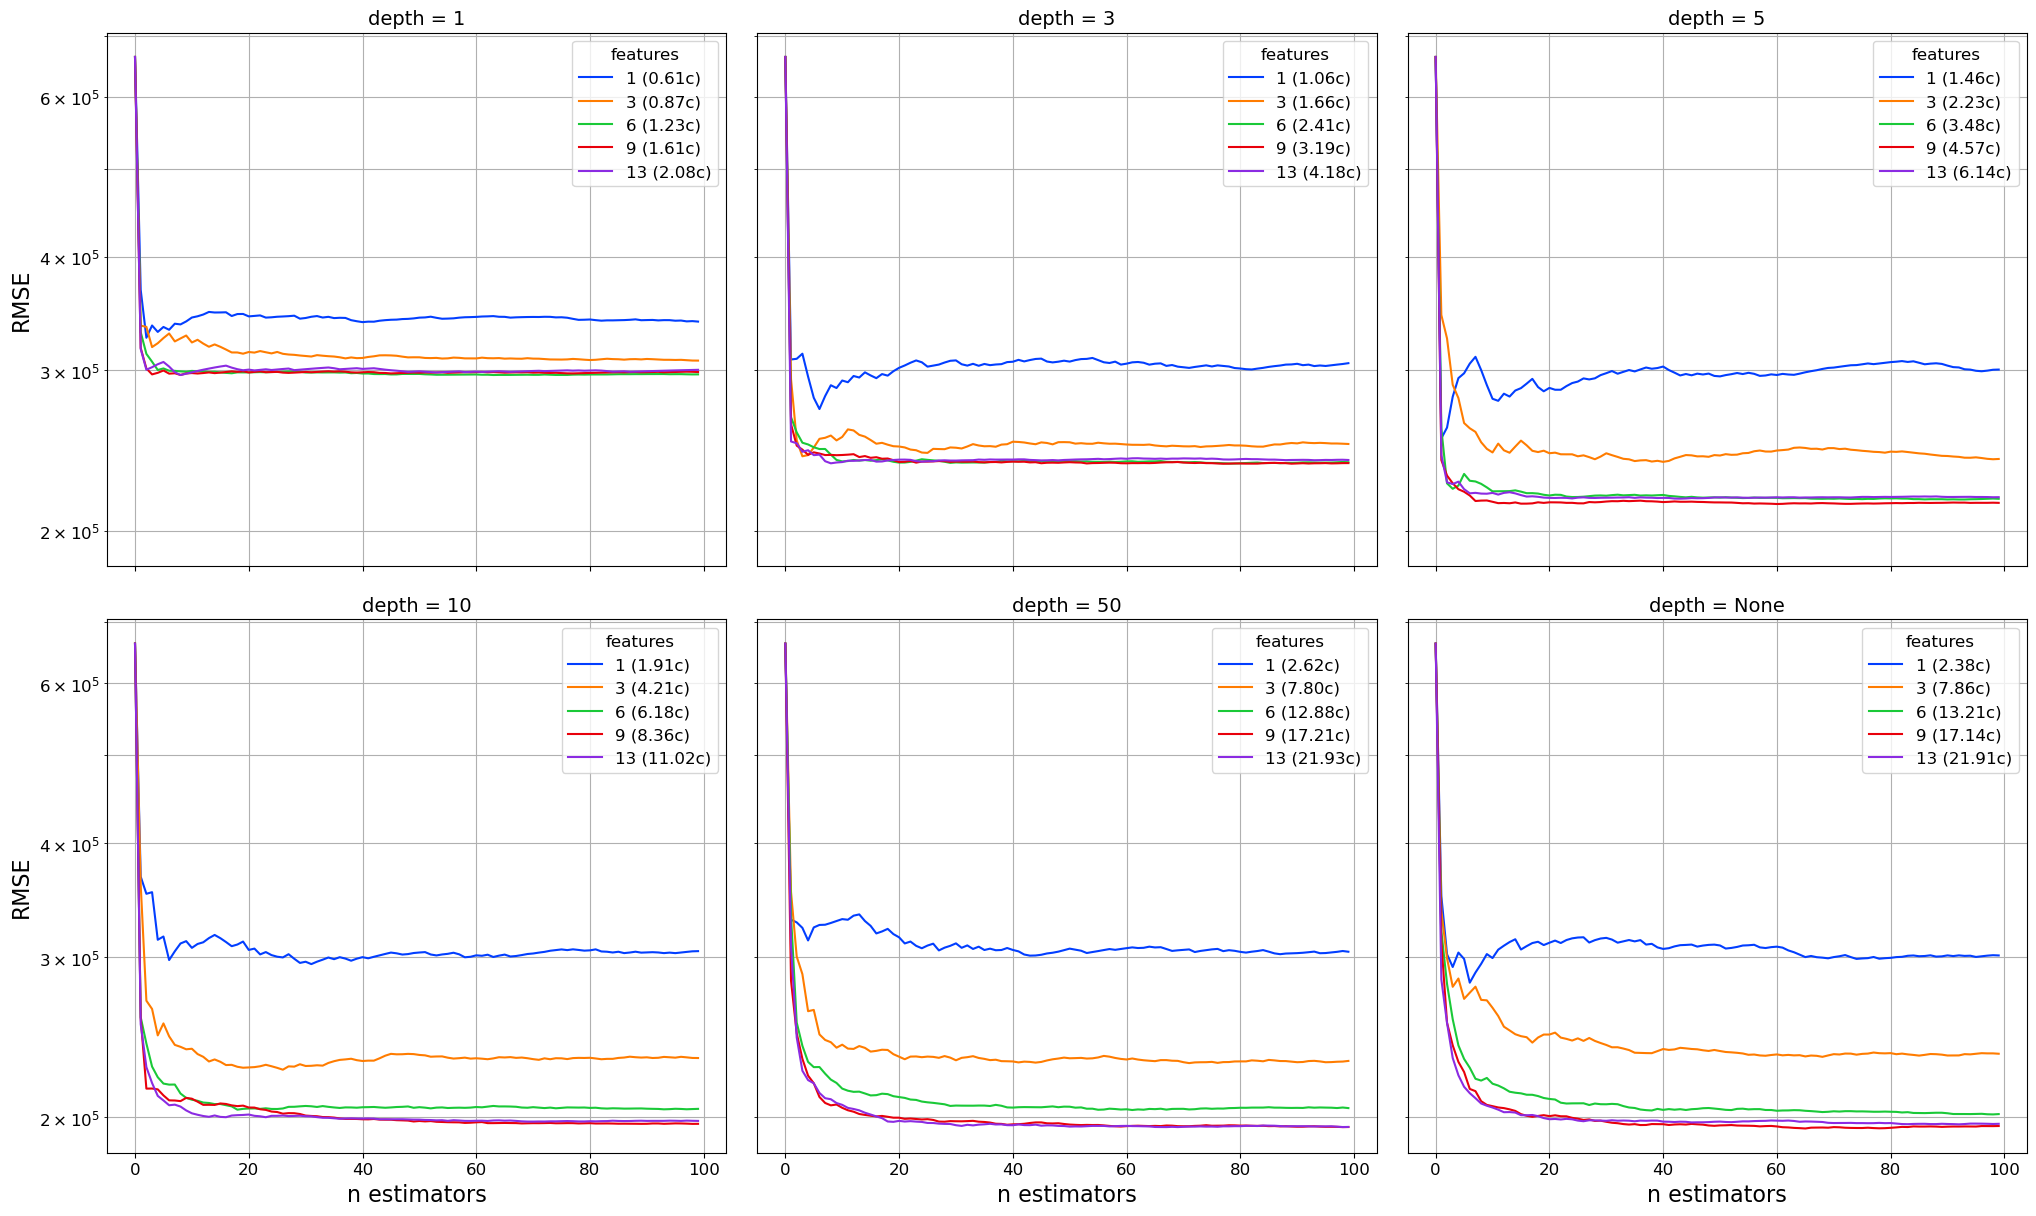

In [433]:
figure, axis = plt.subplots(2, 3, figsize=(24, 16), sharey=True, sharex=True)


plt.subplots_adjust(left=0.1,
                            bottom=0.1,
                            right=0.9,
                            top=0.8,
                            wspace=0.05,
                            hspace=0.1)
matplotlib.rcParams["legend.loc"] = 'upper right'

for i in range(len(trees_dfs)):
    ax = axis.flatten()[i]
    grid = sns.lineplot(data = trees_dfs[i], x = 'n estimators', y = 'RMSE', hue = 'features',  
                    palette='bright', ax=ax)
    ax.set_title('depth = ' + str(depths[i]))
    ax.set_yscale('log')
    grid.grid(True, which='both')

plt.savefig('charts/tree_loss.pdf')
plt.show()

In [434]:
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)

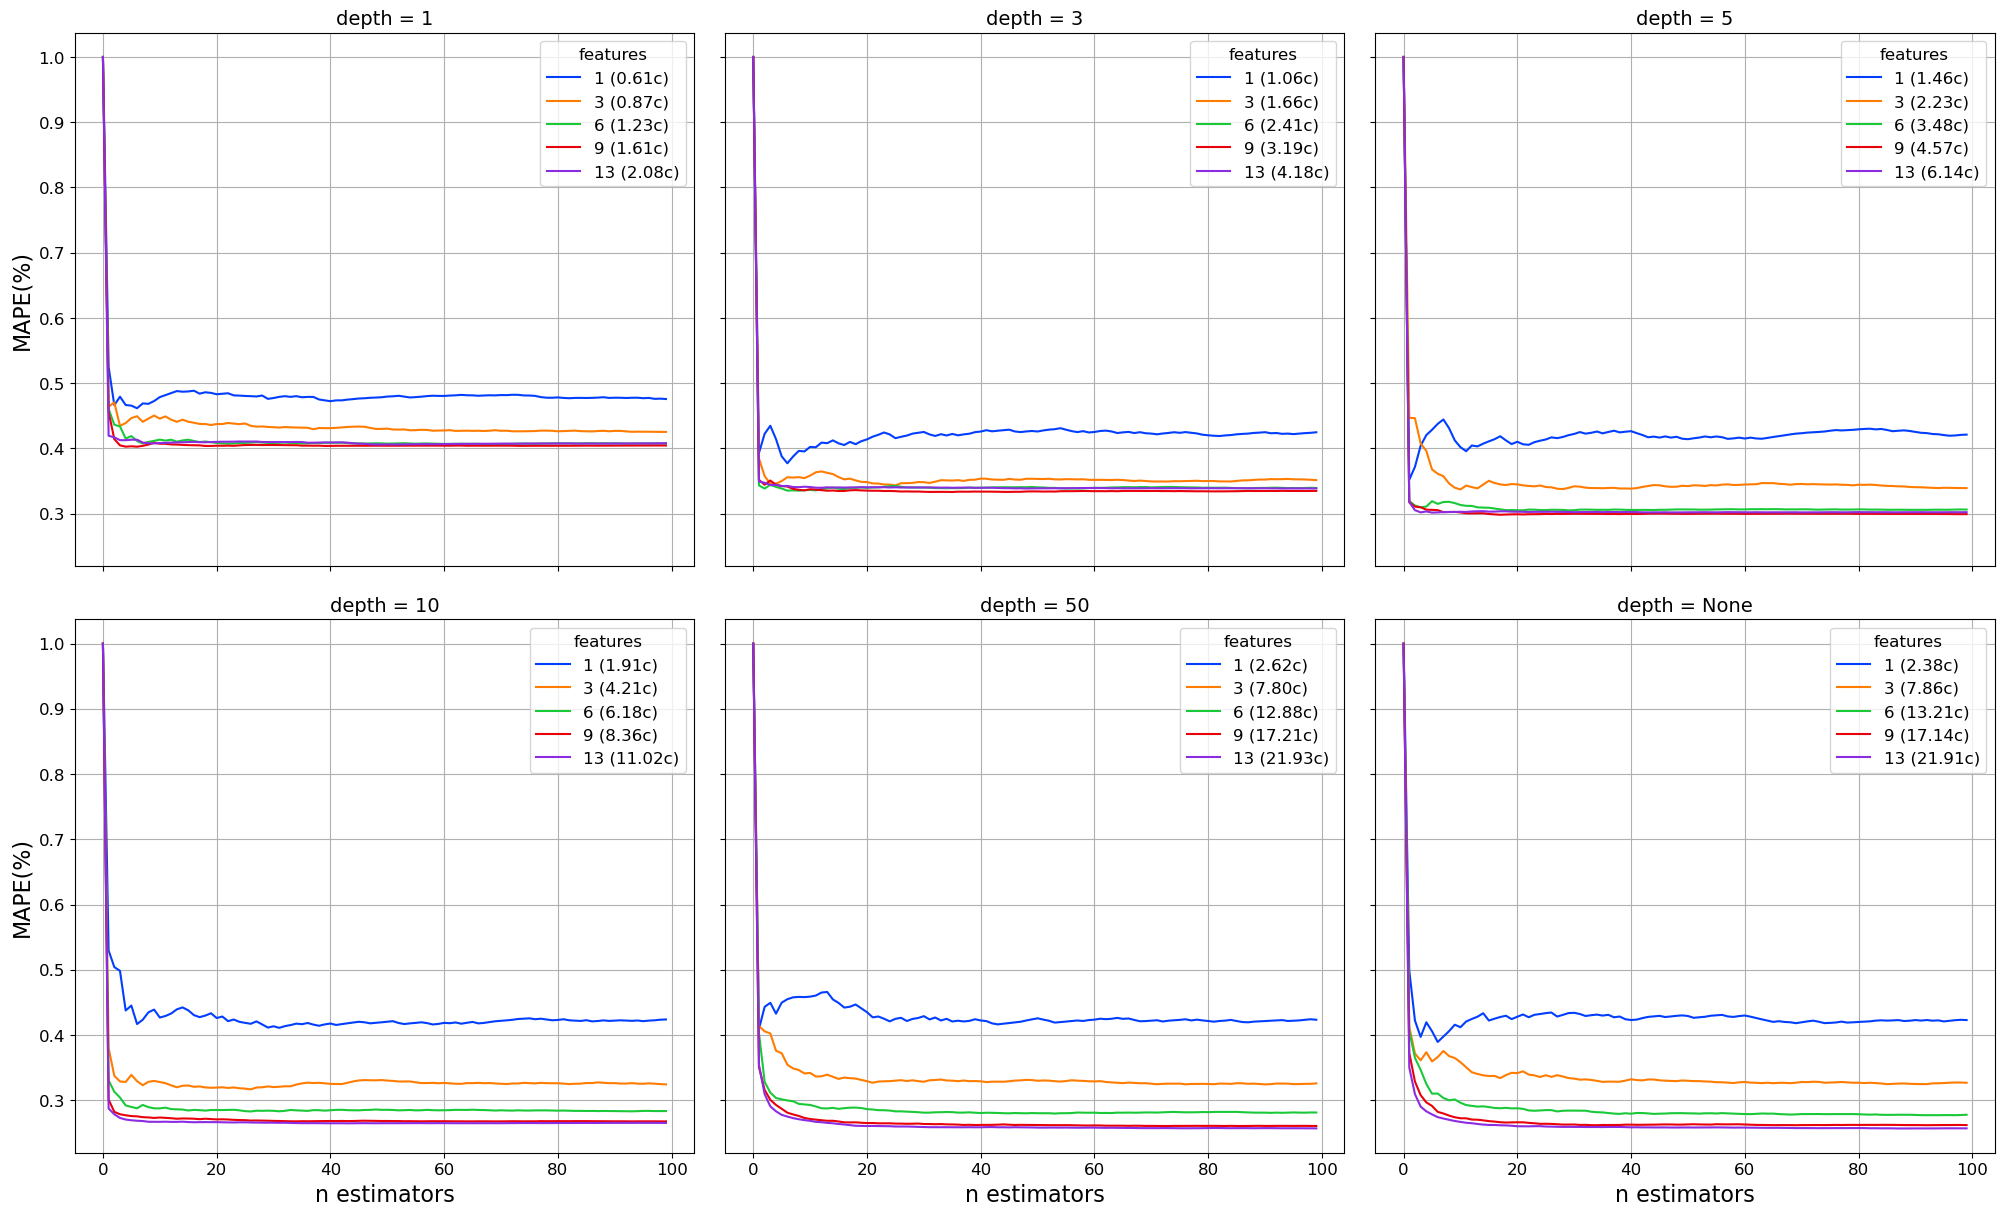

In [435]:
figure, axis = plt.subplots(2, 3, figsize=(24, 16), sharey=True, sharex=True)


plt.subplots_adjust(left=0.1,
                            bottom=0.1,
                            right=0.9,
                            top=0.8,
                            wspace=0.05,
                            hspace=0.1)
matplotlib.rcParams["legend.loc"] = 'upper right'

for i in range(len(trees_dfs)):
    ax = axis.flatten()[i]
    grid = sns.lineplot(data = trees_dfs[i], x = 'n estimators', y = 'MAPE(%)', hue = 'features',  
                    palette='bright', ax=ax)
    ax.set_title('depth = ' + str(depths[i]))

    grid.grid(True, which='both')

plt.savefig('charts/tree_metric.pdf')
plt.show()

In [416]:
%%time
histories1 = []
for max_depth in tqdm(depths):
    for feature_subsample_size in feature_subsample_sizes:
        random_forrest = GradientBoostingMSE(100, max_depth=max_depth, feature_subsample_size=feature_subsample_size)
        histories1.append(random_forrest.fit(X_train, y_train, X_test, y_test, True))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:33<00:00, 35.57s/it]

CPU times: user 3min 31s, sys: 1.24 s, total: 3min 33s
Wall time: 3min 33s


In [417]:
boosting_dfs = []
i = 0
for max_depth in depths:
    dfs = []
    for feature_subsample_size in feature_subsample_sizes:
        history = histories1[i]
        times = np.arange(len(history['loss']))
        loss = history['loss']
        metric = history['metric']
        time = history['time']
        
        df = pd.DataFrame()
        df['RMSE'] = loss
        df['n estimators'] = times
        df['MAPE(%)'] = metric
        df['depth'] = np.repeat(max_depth, len(times))
        df['features'] = f'{int(feature_subsample_size * X_train.shape[1])} ({time:.2f}c)' 
        dfs.append(df)
        i += 1
        
    boosting_dfs.append(pd.concat(dfs, axis=0).reset_index().drop('index', axis=1))

In [436]:
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)

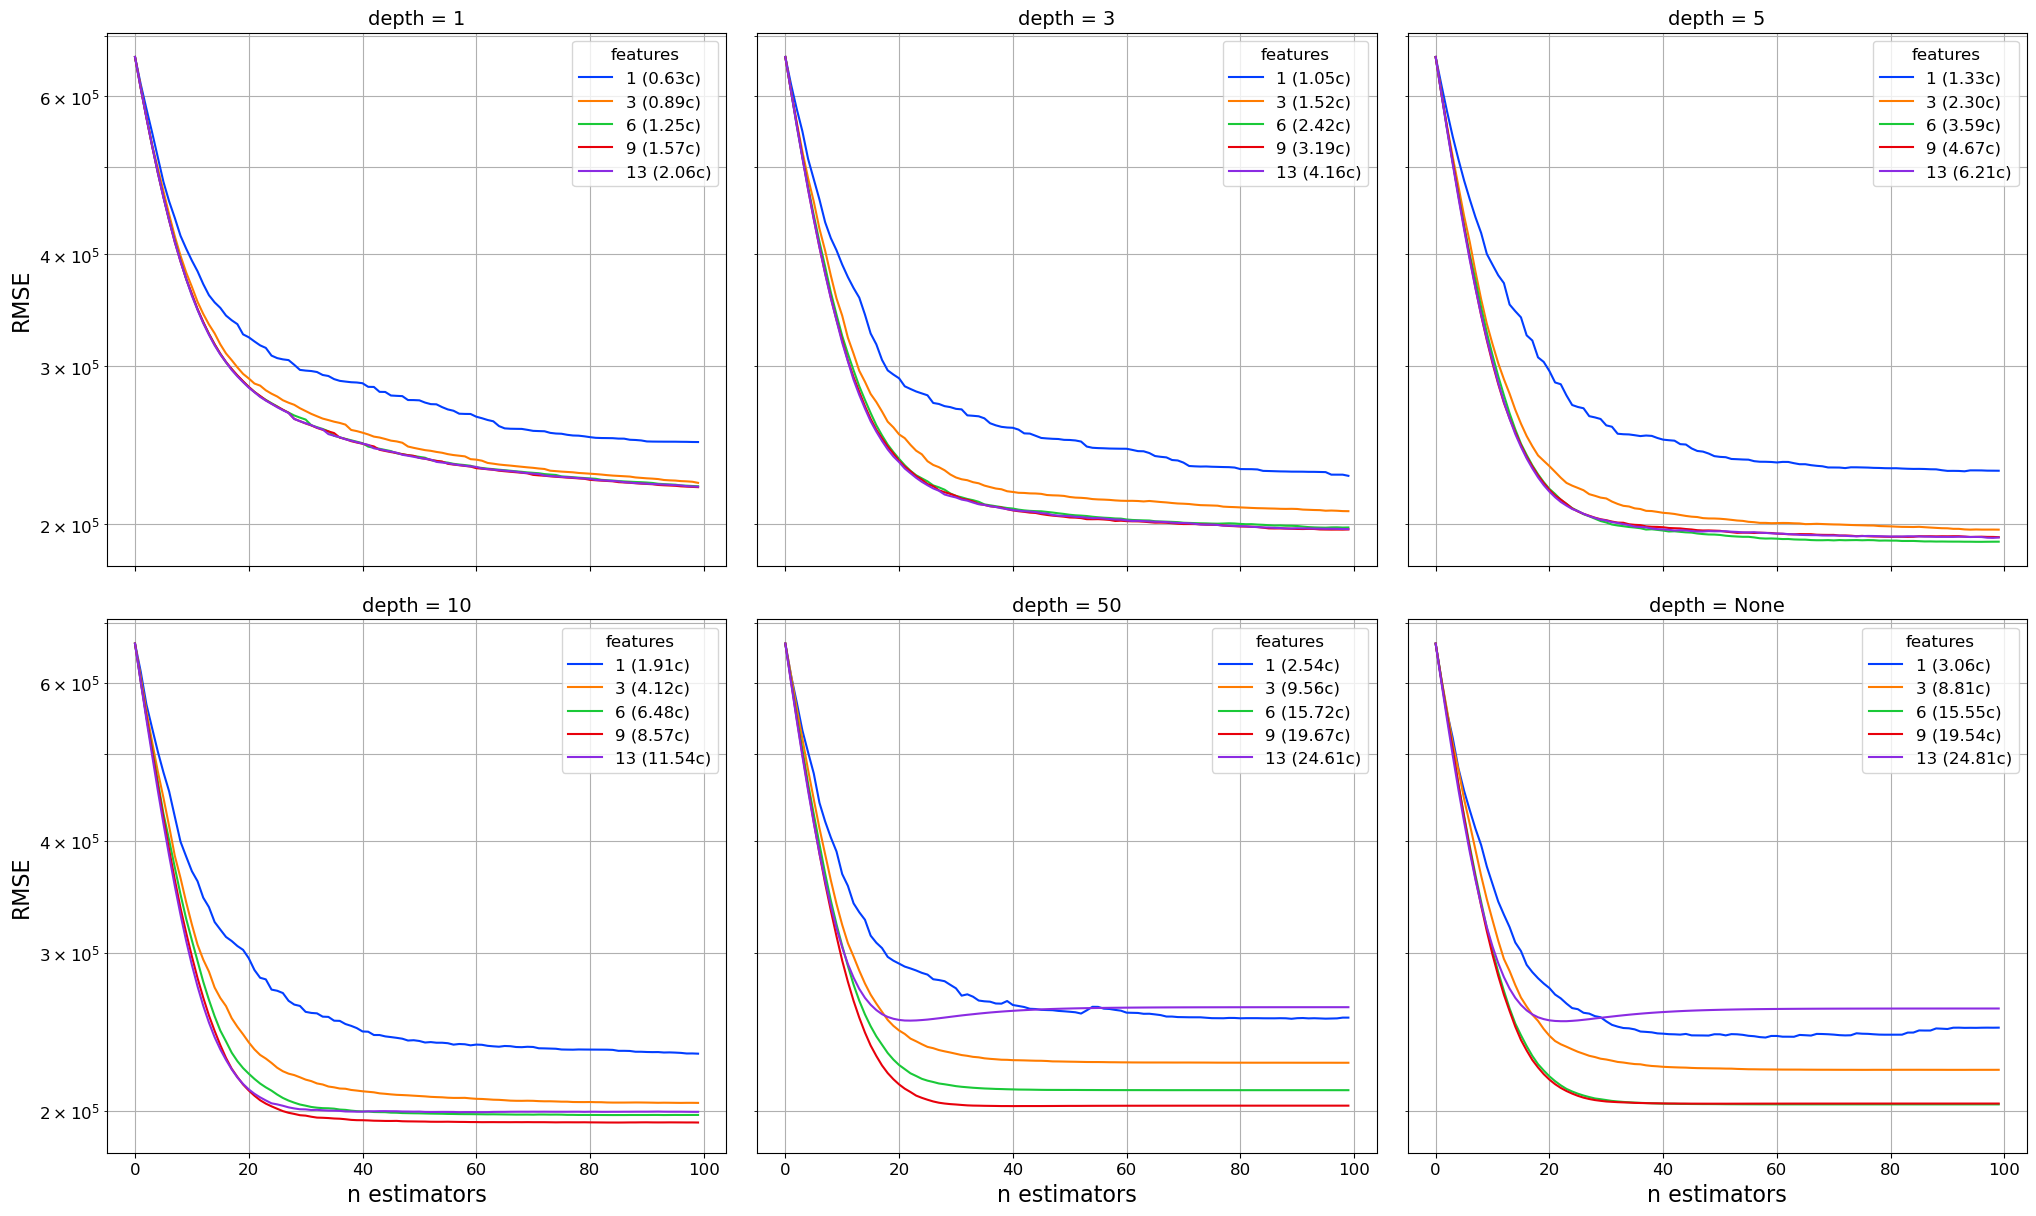

In [437]:
figure, axis = plt.subplots(2, 3, figsize=(24, 16), sharey=True, sharex=True)


plt.subplots_adjust(left=0.1,
                            bottom=0.1,
                            right=0.9,
                            top=0.8,
                            wspace=0.05,
                            hspace=0.1)
matplotlib.rcParams["legend.loc"] = 'upper right'

for i in range(len(boosting_dfs)):
    ax = axis.flatten()[i]
    grid = sns.lineplot(data = boosting_dfs[i], x = 'n estimators', y = 'RMSE', hue = 'features',  
                    palette='bright', ax=ax)
    ax.set_title('depth = ' + str(depths[i]))
    ax.set_yscale('log')

    grid.grid(True, which='both')

plt.savefig('charts/boosting_loss.pdf')
plt.show()

In [438]:
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=12)

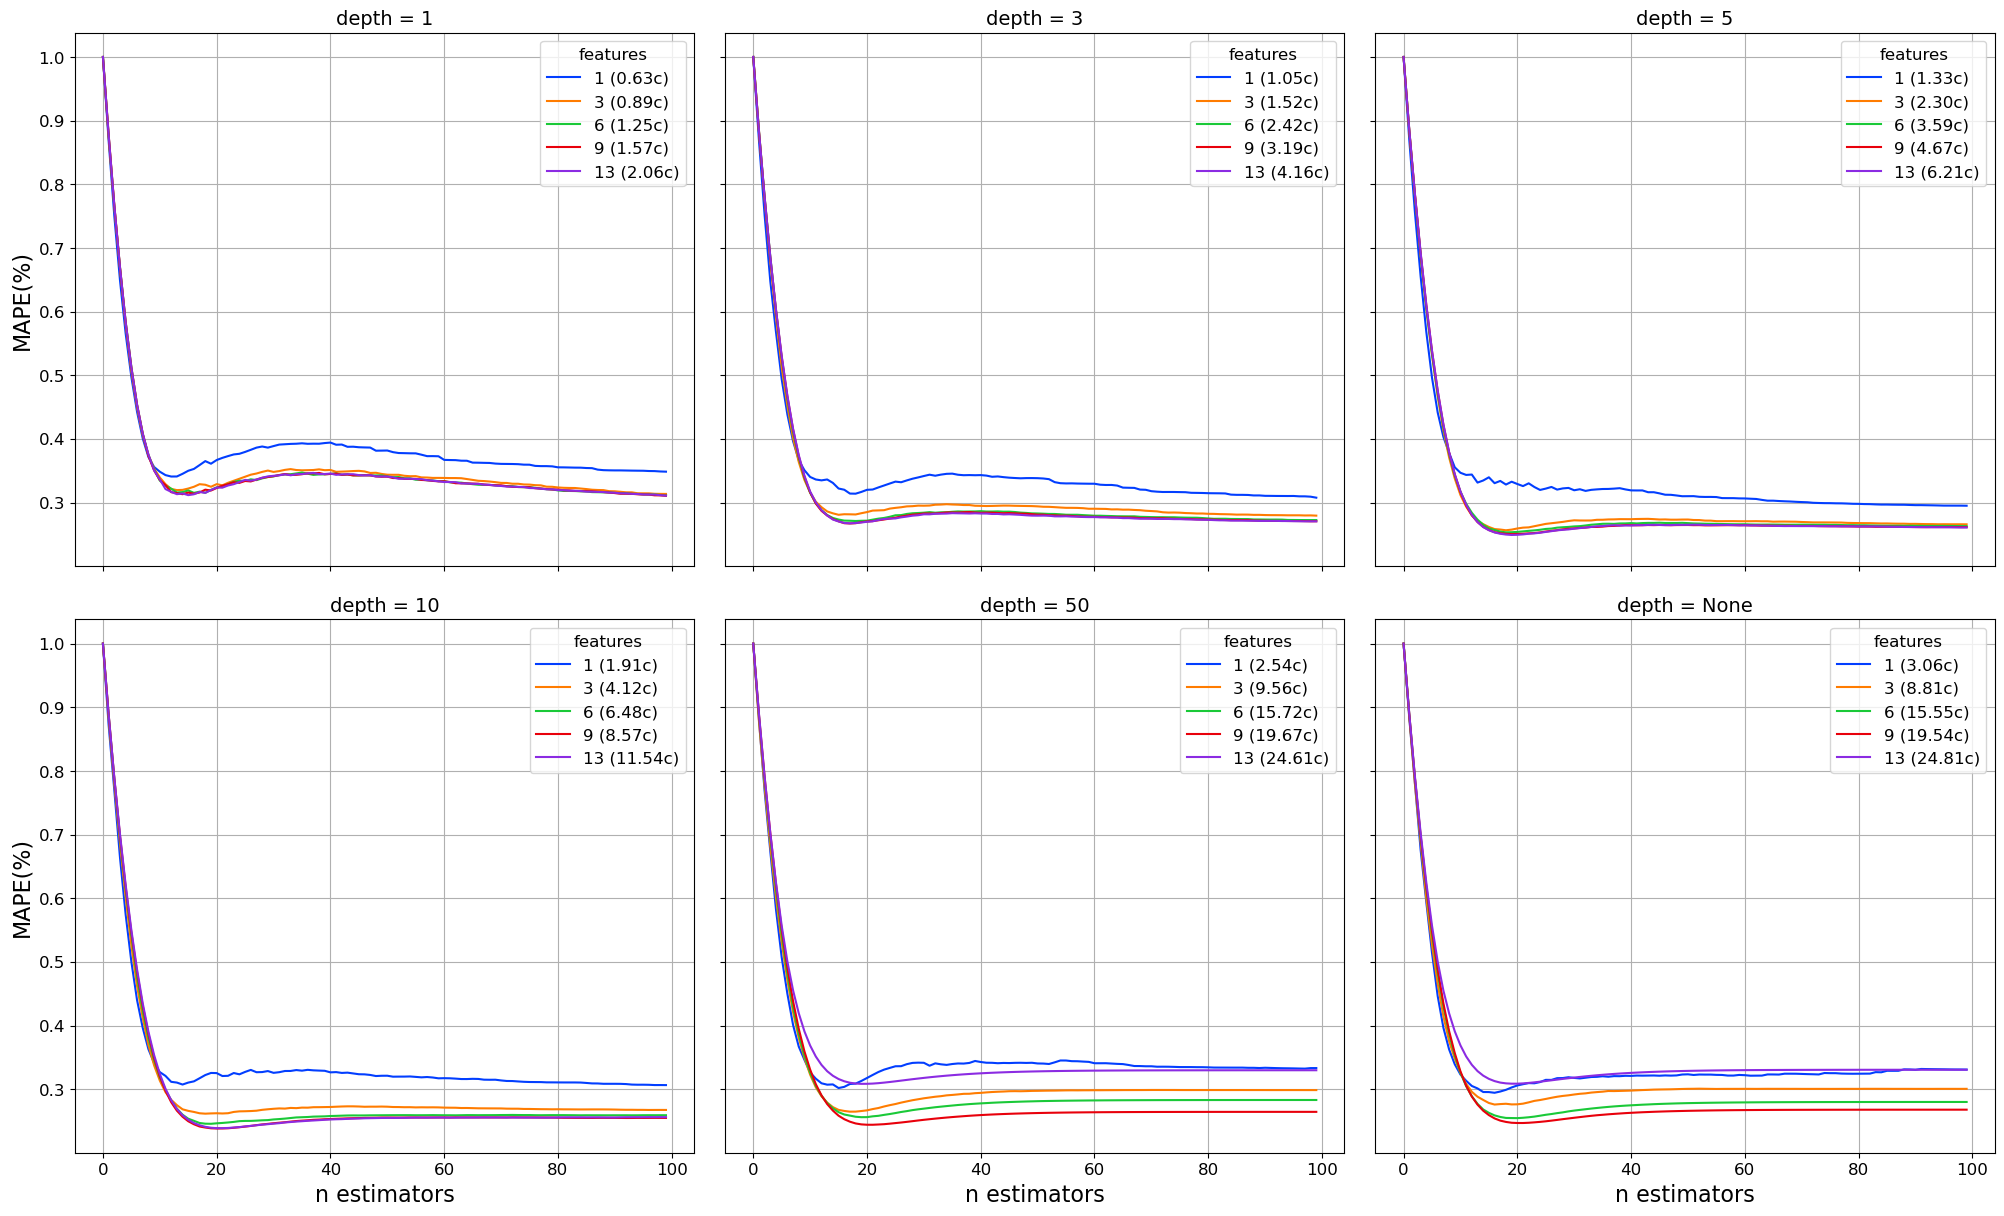

In [439]:
figure, axis = plt.subplots(2, 3, figsize=(24, 16), sharey=True, sharex=True)


plt.subplots_adjust(left=0.1,
                            bottom=0.1,
                            right=0.9,
                            top=0.8,
                            wspace=0.05,
                            hspace=0.1)
matplotlib.rcParams["legend.loc"] = 'upper right'

for i in range(len(boosting_dfs)):
    ax = axis.flatten()[i]
    grid = sns.lineplot(data = boosting_dfs[i], x = 'n estimators', y = 'MAPE(%)', hue = 'features',  
                    palette='bright', ax=ax)
    ax.set_title('depth = ' + str(depths[i]))

    grid.grid(True, which='both')

plt.savefig('charts/boosting_metric.pdf')
plt.show()

In [459]:
%%time
alpha_history = []
for alpha in tqdm(np.logspace(-5,0,6)):
    random_forrest = GradientBoostingMSE(100, max_depth=10, feature_subsample_size=0.75)
    alpha_history.append(random_forrest.fit(X_train, y_train, X_test, y_test, True))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.63s/it]

CPU times: user 51.6 s, sys: 152 ms, total: 51.8 s
Wall time: 51.8 s


In [460]:
dfs = []
for i, alpha in enumerate(np.logspace(-5,0,6)):
    times = np.arange(len(alpha_history[i]['loss']))
    loss = alpha_history[i]['loss']
    time = alpha_history[i]['time']
    
    df = pd.DataFrame()
    df['RMSE'] = loss
    df['n estimators'] = times
    df['alpha'] = np.repeat(alpha, len(times))
    dfs.append(df)
    i += 1
        
alpha_dfs = pd.concat(dfs, axis=0).reset_index().drop('index', axis=1)

In [472]:
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=12)

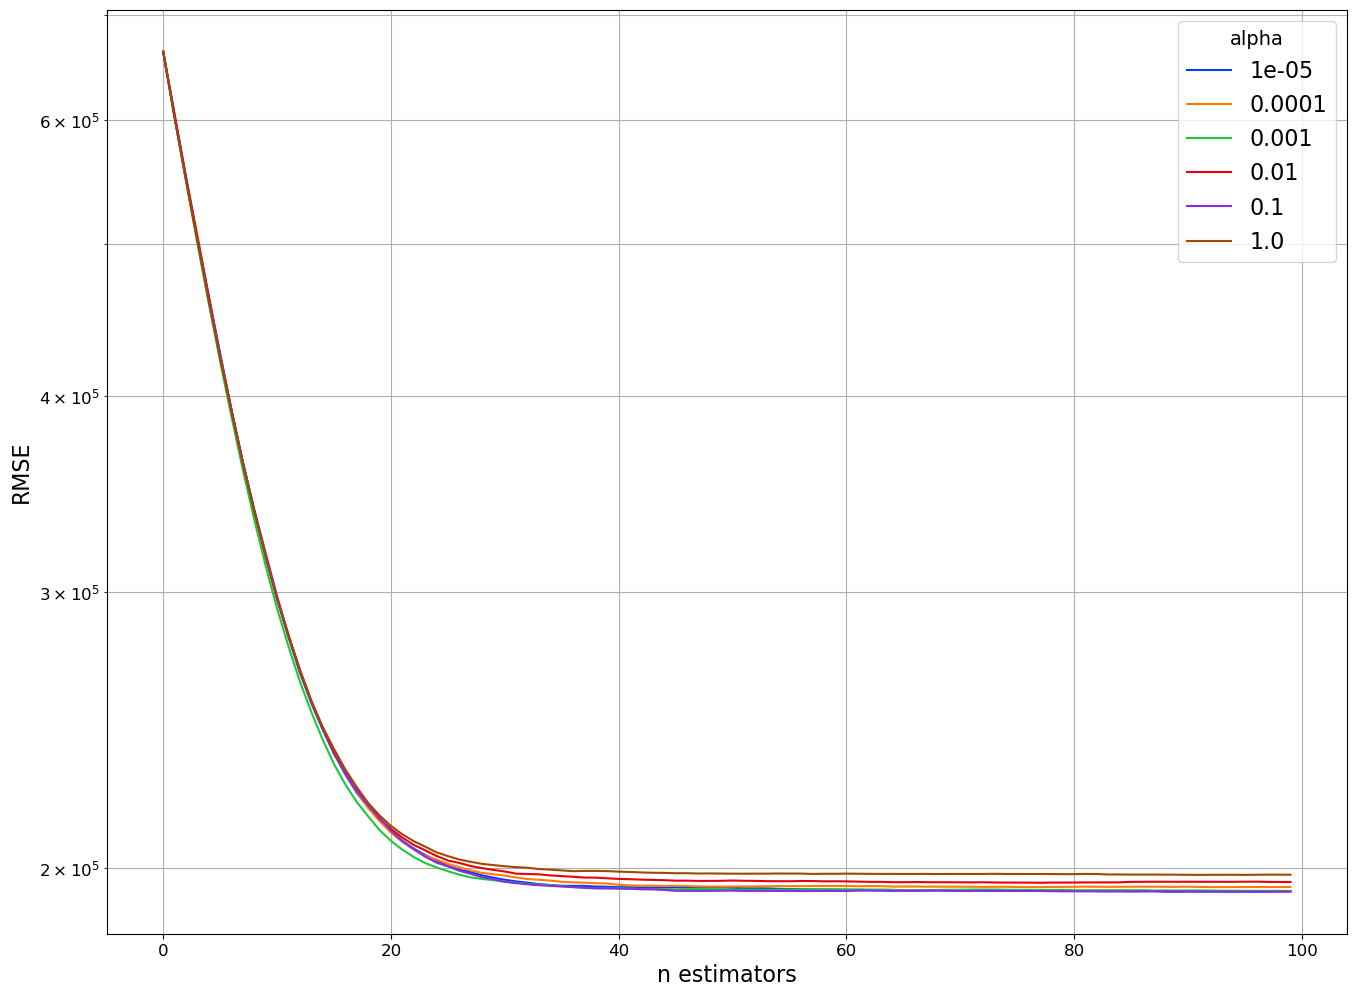

In [474]:
figure, axis = plt.subplots(1, 1, figsize=(16, 12))

matplotlib.rcParams["legend.loc"] = 'upper right'

axis.set_yscale('log')

grid = sns.lineplot(data = alpha_dfs, x = 'n estimators', y = 'RMSE', hue = 'alpha',  
                palette='bright', ax=axis)
grid.grid(True, which='both')

plt.savefig('charts/boosting_alpha.pdf')
plt.show()